## Image Captioning - LSTM Attention

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import sys
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import torchvision.transforms as T

import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SH2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

For reproducibility:

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(46)

Check path to the image files and caption file:

In [3]:
current_dir = Path.cwd()

if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if project_root not in sys.path:
    sys.path.append(str(project_root))

captions_path = project_root / 'data' / 'flickr30k_images' / 'results.csv'
single_captions_path = project_root / 'data' / 'flickr30k_images' / 'single_captions_results.csv'
image_dir = project_root  / 'data' / 'flickr30k_images' / 'flickr30k_images'
image_paths = list(image_dir.glob('*.jpg'))

if captions_path.exists():
    print("Caption path exists")
else:
    print("Caption path does not exist")

if image_dir.exists() and image_dir.is_dir():
    print("Image directory exists")
    
    if image_paths:
        print(f"Found {len(image_paths)} images in the directory.")
    else:
        print("No images found in the directory.")
else:
    print("Image directory does not exist")


Caption path exists
Image directory exists
Found 31783 images in the directory.


Check caption.txt file and get the random raws (7 samples) from it

In [4]:
image_captions = pd.read_csv(captions_path, sep='|')
image_captions.columns = image_captions.columns.str.strip()
image_captions.sample(7)

image_name comment_number  \
68478   3382777250.jpg              3   
11402    170525554.jpg              2   
138363  5812770731.jpg              3   
27114   2385034500.jpg              4   
65696   3328380165.jpg              1   
145877  6839984356.jpg              2   
100312  4467634558.jpg              2   

                                                  comment  
68478    A child in a striped shirt is standing in fro...  
11402    A man in black shirt is taking pictures in a ...  
138363   A young female baseball player slides to home...  
27114              Bikers ride down a busy rural street .  
65696    A man in sunglasses is sitting on top of a pl...  
145877   A youth wearing yellow sits on a wall holding...  
100312   Three children pose for a photograph by a rock .

In [5]:
#Handeling device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Using en_core_web_lg to built vocabulary for our captions. WE are also adding special tokens UNK_TOKEN = 'unk', PAD_TOKEN = 'pad', SOS_TOKEN = 'sos', EOS_TOKEN = 'eos' to our vocabulary:

In [6]:
from src.vocab_builder import VocabularyBuilder

image_captions['comment'] = image_captions['comment'].apply(lambda x: x if isinstance(x, str) else '')
text_lines = image_captions['comment'].tolist()

if Path.cwd().name == 'notebooks':
    os.chdir("..")

#Uncomment or comment if you want to load or build/save
vocab_builder = VocabularyBuilder(min_freq=2, save_path='./saved_model/vocab_full.pth', special_token=True)
#vocab = vocab_builder.build_vocab(text_lines)
vocab = vocab_builder.load_vocab(device)


In [7]:
words = vocab.get_itos()
vocab_length = len(vocab)
print(f"Total number of words in vocab: {vocab_length}")

Total number of words in vocab: 12102


Defining dataloader for our dataset and also split dataset into train and test sets

In [8]:
from src.image_caption_dataset import ImageCaptionDataset

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

image_paths = [str(p).lower() for p in image_paths]
captions_df = pd.read_csv(captions_path, sep='|')
captions_df.columns = captions_df.columns.str.strip()
captions_df['image_name'] = captions_df['image_name'].str.strip().str.lower()
captions_df = captions_df.dropna(subset=['comment'])

captions_df = captions_df.groupby('image_name').first().reset_index()#only one caption

captions_df['image_path'] = captions_df['image_name'].apply(
    lambda x: next((p for p in image_paths if x in p), None)
)

captions_df = captions_df.dropna(subset=['image_path'])


if len(captions_df) > 0:
    train_df, val_test_df = train_test_split(captions_df, test_size=0.09, random_state=42)
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)
    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")
else:
    raise ValueError("No valid data available for splitting. Check your captions file and image paths.")

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

transforms = T.Compose([
    T.Resize((224, 224)), 
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])




Train set size: 28922
Validation set size: 1430
Test set size: 1431
Train size: 28922, Validation size: 1430, Test size: 1431


In [9]:
train_dataset = ImageCaptionDataset(
    image_paths=train_df['image_path'].tolist(),
    captions=train_df['comment'].tolist(),
    vocabulary_builder=vocab_builder,
    transform=transforms
)

val_dataset = ImageCaptionDataset(
    image_paths=val_df['image_path'].tolist(),
    captions=val_df['comment'].tolist(),
    vocabulary_builder=vocab_builder,
    transform=transforms
)

test_dataset = ImageCaptionDataset(
    image_paths=test_df['image_path'].tolist(),
    captions=test_df['comment'].tolist(),
    vocabulary_builder=vocab_builder,
    transform=transforms
)

In [ ]:
from src.utils import save_dataset_as_csv

save_dataset_as_csv(train_dataset, "train_dataset.csv")
save_dataset_as_csv(val_dataset, "val_dataset.csv")
save_dataset_as_csv(test_dataset, "test_dataset.csv")

Dataset saved to train_dataset.csv
Dataset saved to val_dataset.csv
Dataset saved to test_dataset.csv


In [12]:
from src.batch_caption_collator import BatchCaptionCollator

pad_idx = vocab_builder.vocabulary['<pad>']
batch_size = 80
num_workers = 4
prefetch_factor = 2
max_sentence_length = 50

collator = BatchCaptionCollator(pad_idx=pad_idx, max_len=max_sentence_length, batch_first=True)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)


## LSTM With Attention

In [ ]:
vocab_size = len(vocab_builder.vocabulary)

emb_size = 128

attn_size = 64
drop_prob = 0.2
enc_hidden_size = 2048
dec_hidden_size = 128

learning_rate = 1e-3
num_epochs = 50
print_every = 300

backbone="resnet50"

transformation=None

save_dir = "saved_model"

In [17]:
from src.models.encoderdecoder import EncoderDecoder

model_Attention = EncoderDecoder(
    emb_size = emb_size,
    vocab_size = vocab_size,
    attn_size = attn_size,
    enc_hidden_size = enc_hidden_size,
    dec_hidden_size = dec_hidden_size,
    drop_prob = drop_prob,
    device = device,
    use_attention=True,
    transformation=transformation,
    max_len=max_sentence_length
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
optimizer = optim.Adam(model_Attention.parameters(), lr = learning_rate)

In [ ]:
from src.utils import EarlyStopping

earlystopping_patience = 2
#LR_patience = 2
#LR_factor = 0.1

early_stopping = EarlyStopping(patience=earlystopping_patience, min_delta=0.001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_factor, patience=LR_patience, verbose=True)

Epoch: 1, Batch: 300, Training Loss: 4.78673

Original Caption:  A dark-haired woman in a black , sparkly outfit is cheering in front of a yellow banner that says " Cheer " .
Generated Caption: a man in a black shirt and a black shirt and a black shirt and a black and a black and a black and a black and a black and a black and a black and a black and a black and a black and a black and a black


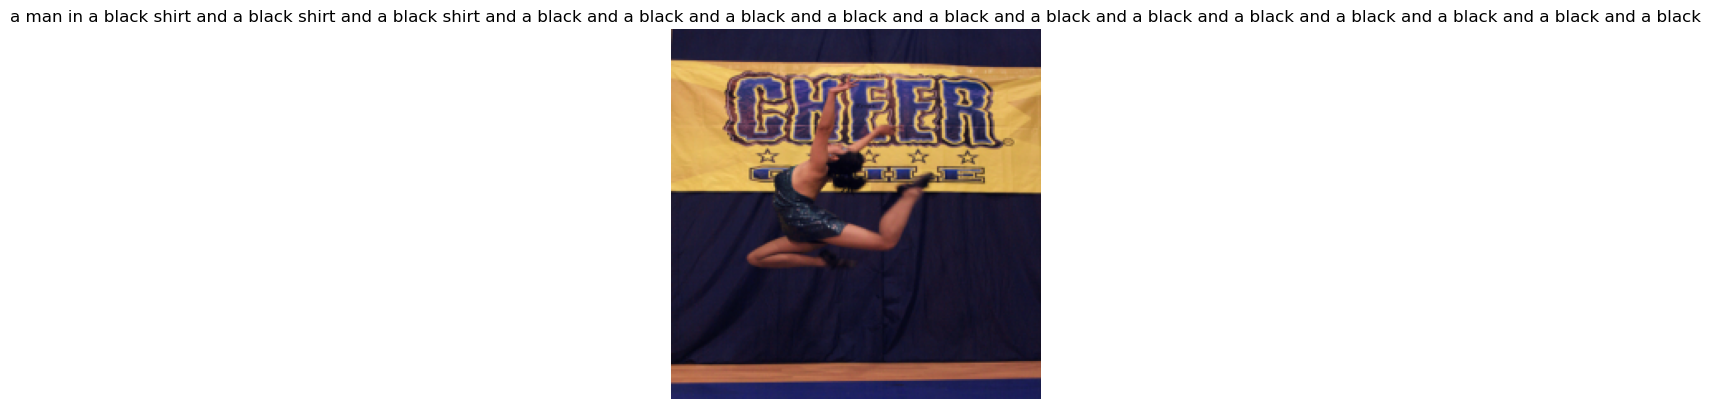

Epoch 1/50 - Train Loss: 5.3971, Val Loss: 4.6115, BLEU: 0.0114, ROUGE-1: 0.1229, ROUGE-2: 0.0275, ROUGE-L: 0.1156, ROUGE-Lsum: 0.1156
Saved checkpoint for epoch 1 at saved_model\LSTM_with_Attention_resnet50_None_epoch_1.pth.gz
Epoch: 2, Batch: 300, Training Loss: 4.27977

Original Caption:  A boy is riding a skateboard down a slope that leads from a bridge to the street below .
Generated Caption: a man in a blue shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt


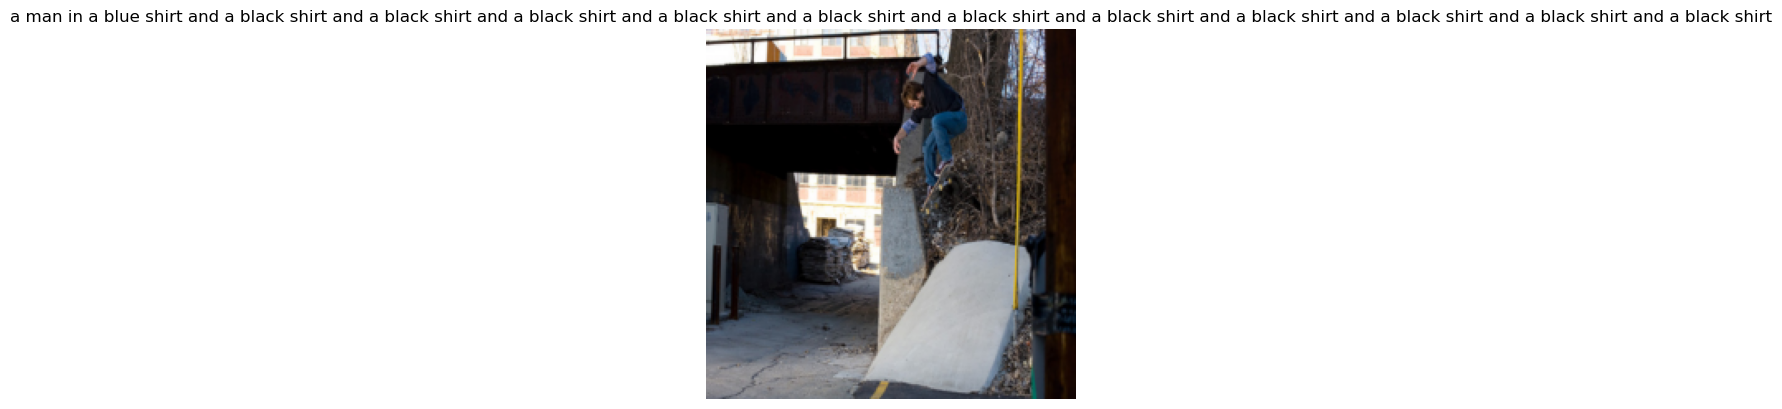

Epoch 2/50 - Train Loss: 4.4233, Val Loss: 4.1732, BLEU: 0.0193, ROUGE-1: 0.1813, ROUGE-2: 0.0496, ROUGE-L: 0.1661, ROUGE-Lsum: 0.1661
Saved checkpoint for epoch 2 at saved_model\LSTM_with_Attention_resnet50_None_epoch_2.pth.gz
Epoch: 3, Batch: 300, Training Loss: 3.98043

Original Caption:  A young girl wearing a pink dress jumps through the air over playground equipment .
Generated Caption: a man in a blue shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt


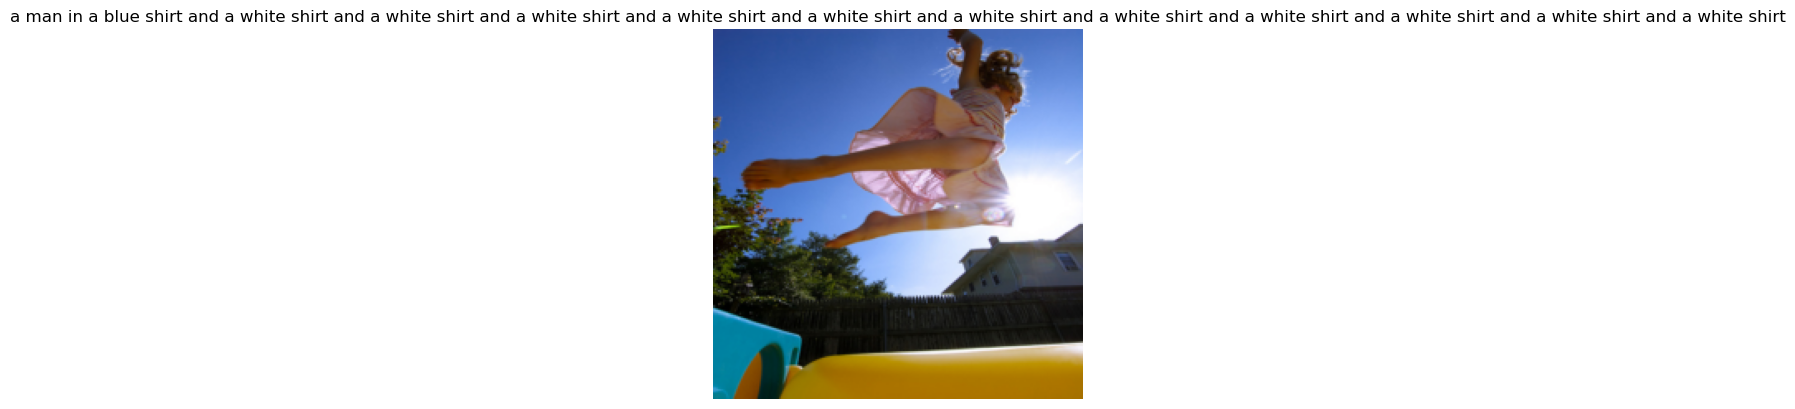

Epoch 3/50 - Train Loss: 4.1017, Val Loss: 3.9683, BLEU: 0.0269, ROUGE-1: 0.2273, ROUGE-2: 0.0670, ROUGE-L: 0.2039, ROUGE-Lsum: 0.2038
Saved checkpoint for epoch 3 at saved_model\LSTM_with_Attention_resnet50_None_epoch_3.pth.gz
Epoch: 4, Batch: 300, Training Loss: 3.81537

Original Caption:  Two older men speak into microphones on a stage , while a projector screen displays a vintage photo of a young man behind them .
Generated Caption: a man in a black shirt and a black shirt is sitting on a stage with a man in a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt and a black shirt


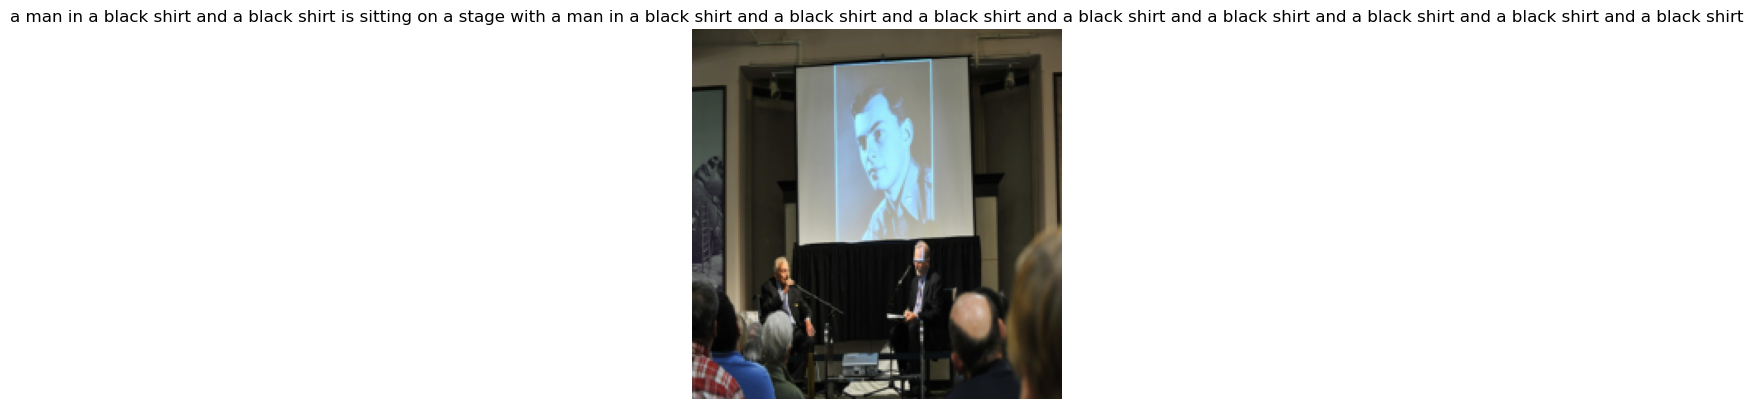

Epoch 4/50 - Train Loss: 3.9060, Val Loss: 3.8406, BLEU: 0.0241, ROUGE-1: 0.2038, ROUGE-2: 0.0602, ROUGE-L: 0.1864, ROUGE-Lsum: 0.1865
Saved checkpoint for epoch 4 at saved_model\LSTM_with_Attention_resnet50_None_epoch_4.pth.gz
Epoch: 5, Batch: 300, Training Loss: 3.82721

Original Caption:  On the road there is one man with a wagon and two cattle passing an Isuzu truck which is carrying three men .
Generated Caption: a man in a blue shirt and a black shirt and a black shirt and a man is standing on a street <eos>


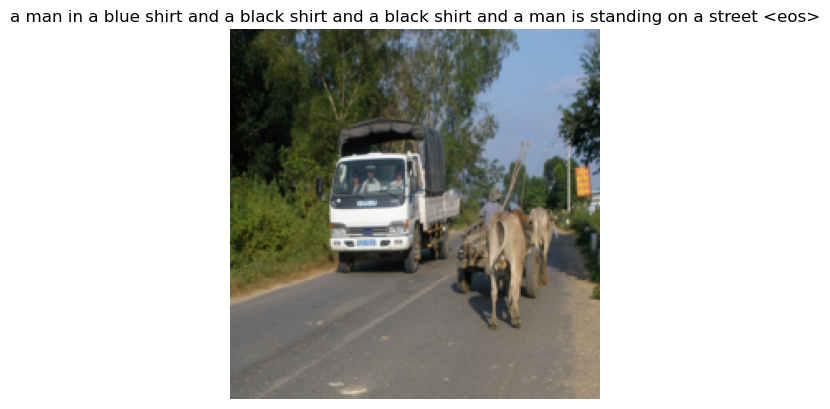

Epoch 5/50 - Train Loss: 3.7621, Val Loss: 3.7540, BLEU: 0.0268, ROUGE-1: 0.2202, ROUGE-2: 0.0672, ROUGE-L: 0.1988, ROUGE-Lsum: 0.1989
Saved checkpoint for epoch 5 at saved_model\LSTM_with_Attention_resnet50_None_epoch_5.pth.gz
Epoch: 6, Batch: 300, Training Loss: 3.58206

Original Caption:  A young Asian girl is wearing a pink dress and holding an umbrella even though it is not raining .
Generated Caption: a woman in a white dress and a white dress and a woman in a pink dress and a white dress and a white dress and a woman in a pink dress and a white dress and a white dress and a woman in a pink dress and a white


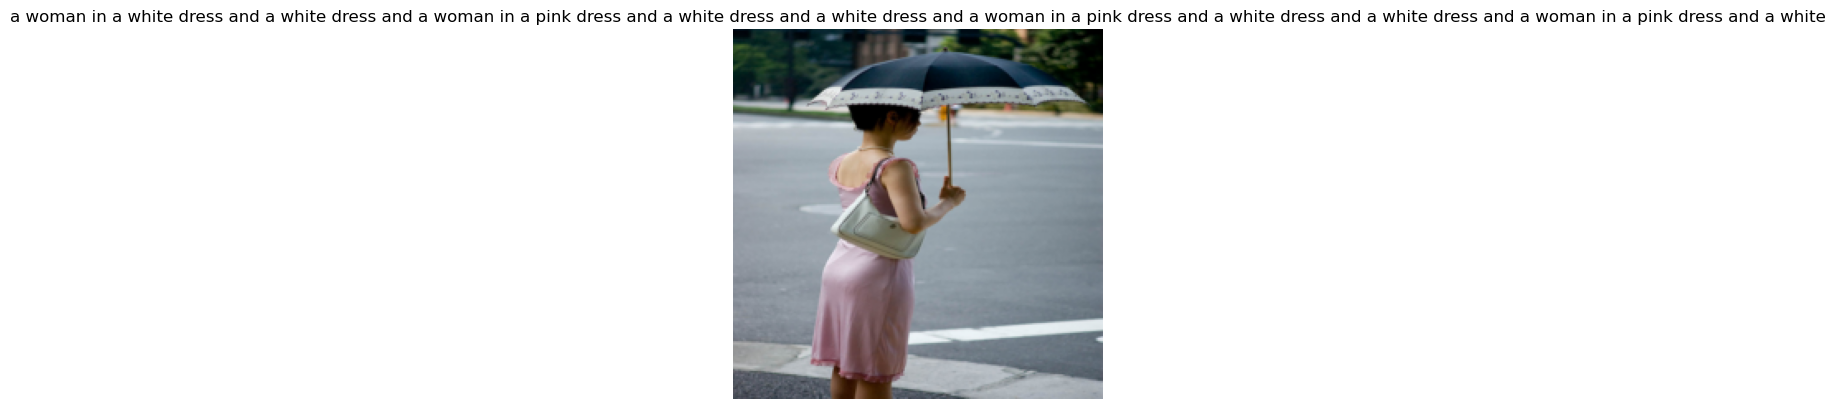

Epoch 6/50 - Train Loss: 3.6464, Val Loss: 3.6942, BLEU: 0.0265, ROUGE-1: 0.2139, ROUGE-2: 0.0647, ROUGE-L: 0.1953, ROUGE-Lsum: 0.1951
Saved checkpoint for epoch 6 at saved_model\LSTM_with_Attention_resnet50_None_epoch_6.pth.gz
Epoch: 7, Batch: 300, Training Loss: 3.61518

Original Caption:  For people in white , red , and blue cycling clothes cycle around a corner on a wooden track .
Generated Caption: a man in a blue shirt and black pants and a black shirt is standing on a skateboard in a blue and white and white and white and white and white and white and white and white and white and white and white and white and white and white and


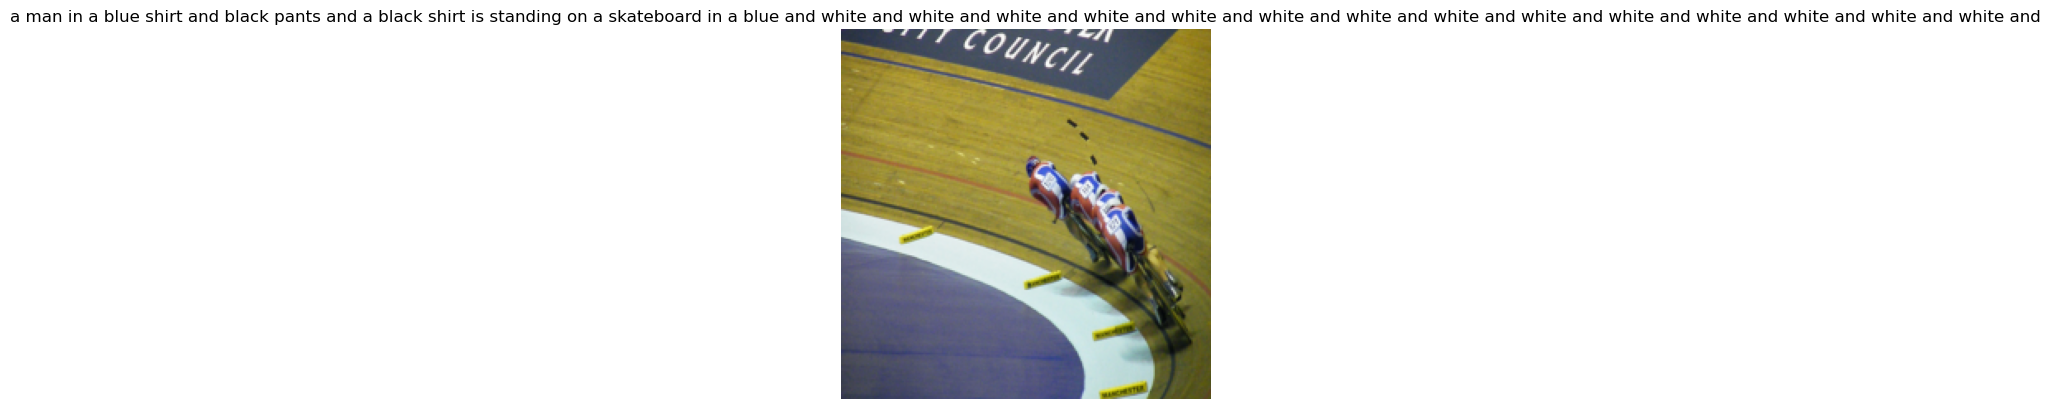

Epoch 7/50 - Train Loss: 3.5513, Val Loss: 3.6438, BLEU: 0.0364, ROUGE-1: 0.2582, ROUGE-2: 0.0806, ROUGE-L: 0.2302, ROUGE-Lsum: 0.2304
Saved checkpoint for epoch 7 at saved_model\LSTM_with_Attention_resnet50_None_epoch_7.pth.gz
Epoch: 8, Batch: 300, Training Loss: 3.44053

Original Caption:  A smiling old man with a mustache displays the process of flattening and curing meat .
Generated Caption: a man in a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt


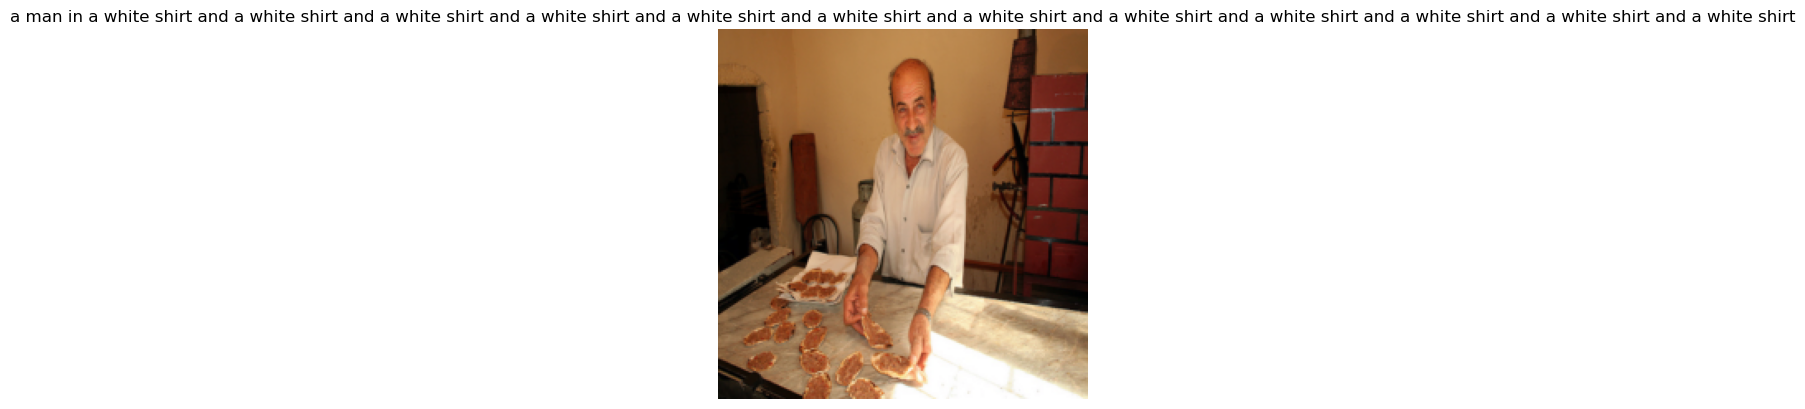

Epoch 8/50 - Train Loss: 3.4678, Val Loss: 3.6124, BLEU: 0.0357, ROUGE-1: 0.2533, ROUGE-2: 0.0789, ROUGE-L: 0.2268, ROUGE-Lsum: 0.2268
Saved checkpoint for epoch 8 at saved_model\LSTM_with_Attention_resnet50_None_epoch_8.pth.gz
Epoch: 9, Batch: 300, Training Loss: 3.41306

Original Caption:  A man in glasses is sitting behind a table laden with military memorabilia .
Generated Caption: a man in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a black shirt and a black shirt is sitting on a table <eos>


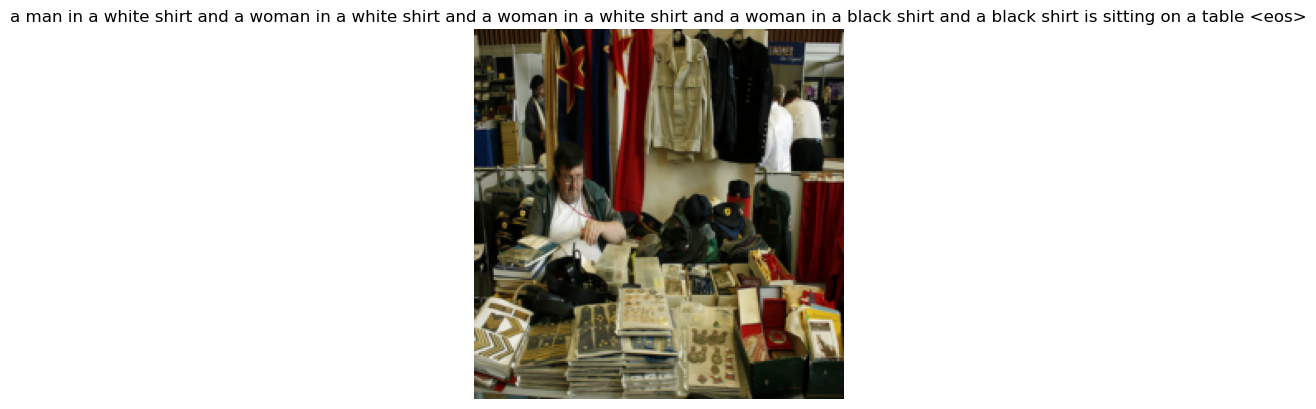

Epoch 9/50 - Train Loss: 3.3921, Val Loss: 3.5853, BLEU: 0.0417, ROUGE-1: 0.2749, ROUGE-2: 0.0876, ROUGE-L: 0.2449, ROUGE-Lsum: 0.2451
Saved checkpoint for epoch 9 at saved_model\LSTM_with_Attention_resnet50_None_epoch_9.pth.gz
Epoch: 10, Batch: 300, Training Loss: 3.31667

Original Caption:  A woman with gloves and a suit on stare at something as a cello player sits in the background .
Generated Caption: a man in a black jacket is sitting on a stage with a microphone <eos>


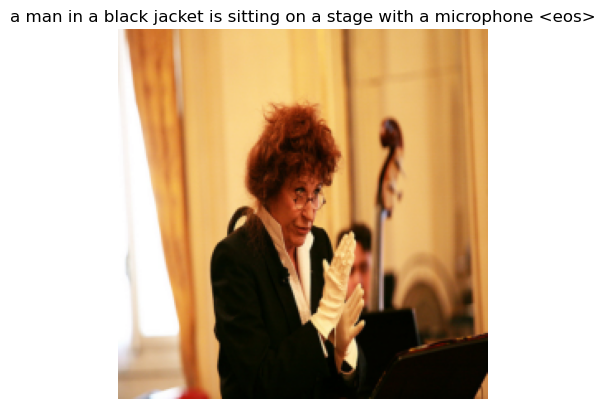

Epoch 10/50 - Train Loss: 3.3242, Val Loss: 3.5618, BLEU: 0.0423, ROUGE-1: 0.2701, ROUGE-2: 0.0872, ROUGE-L: 0.2406, ROUGE-Lsum: 0.2408
Saved checkpoint for epoch 10 at saved_model\LSTM_with_Attention_resnet50_None_epoch_10.pth.gz
Epoch: 11, Batch: 300, Training Loss: 3.28441

Original Caption:  A woman with glasses wearing a green knitted hat pushes a red baby stroller down an unpaved pathway .
Generated Caption: a woman in a red jacket and a woman in a red jacket and a woman in a black jacket and a black jacket and a woman in a black jacket and a black jacket and a woman in a black jacket and a black jacket and a woman in


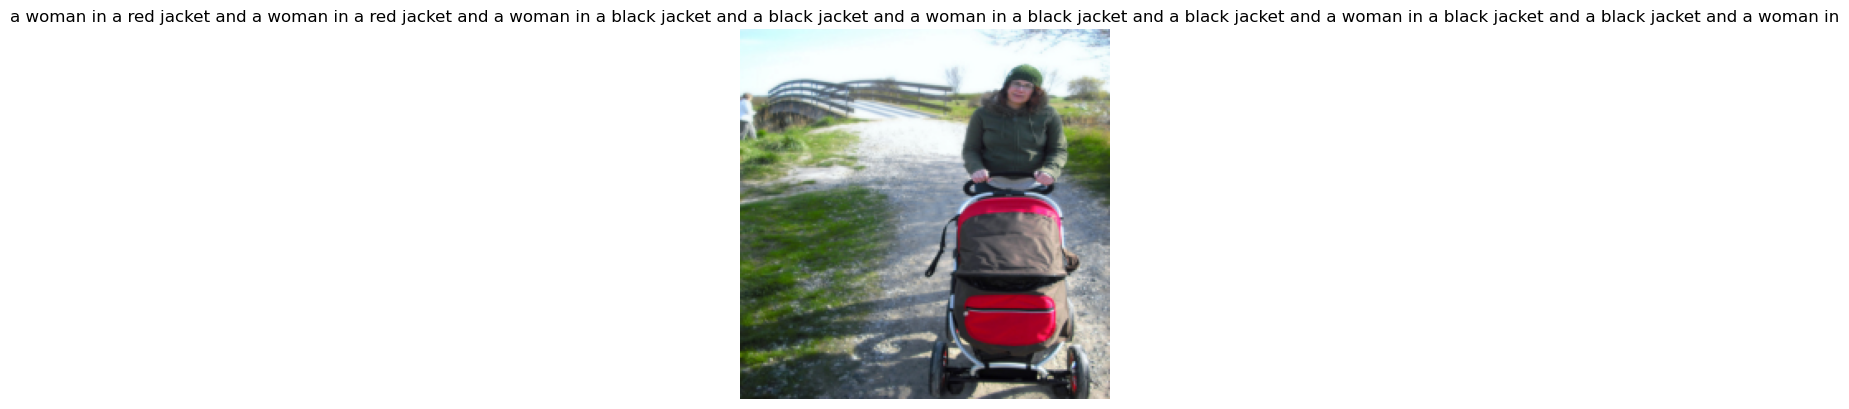

Epoch 11/50 - Train Loss: 3.2610, Val Loss: 3.5472, BLEU: 0.0454, ROUGE-1: 0.2833, ROUGE-2: 0.0892, ROUGE-L: 0.2494, ROUGE-Lsum: 0.2495
Saved checkpoint for epoch 11 at saved_model\LSTM_with_Attention_resnet50_None_epoch_11.pth.gz
Epoch: 12, Batch: 300, Training Loss: 3.23839

Original Caption:  Two men in black jackets sit on a white bench at night on a cobbled courtyard .
Generated Caption: a man in a white shirt and a white shirt is walking down a sidewalk in front of a building <eos>


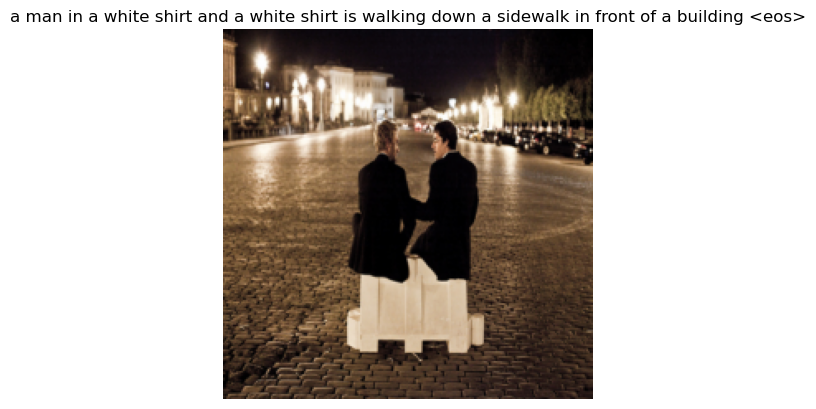

Epoch 12/50 - Train Loss: 3.2018, Val Loss: 3.5398, BLEU: 0.0495, ROUGE-1: 0.2931, ROUGE-2: 0.0921, ROUGE-L: 0.2575, ROUGE-Lsum: 0.2577
Saved checkpoint for epoch 12 at saved_model\LSTM_with_Attention_resnet50_None_epoch_12.pth.gz
Epoch: 13, Batch: 300, Training Loss: 3.16967

Original Caption:  Three dogs are turning direction along a snow tread leading from a low cut field .
Generated Caption: a brown dog is running through the snow with a dog in the snow <eos>


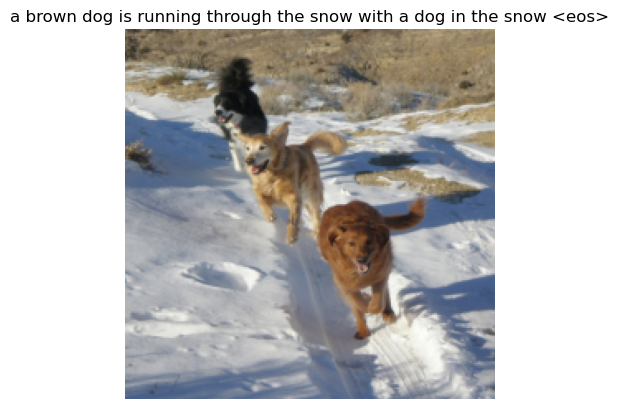

Epoch 13/50 - Train Loss: 3.1475, Val Loss: 3.5286, BLEU: 0.0471, ROUGE-1: 0.2885, ROUGE-2: 0.0922, ROUGE-L: 0.2541, ROUGE-Lsum: 0.2541
Saved checkpoint for epoch 13 at saved_model\LSTM_with_Attention_resnet50_None_epoch_13.pth.gz
Epoch: 14, Batch: 300, Training Loss: 3.21722

Original Caption:  What looks to be a Japanese couple stand close to each other , the boy in a white shirt , the girl in a yellow , against the railing of a walkway .
Generated Caption: two men in a white and white and white shirts and a white and white and white and white shirts and a white and white and white and white and white and white and white and white and white and white and white and white and white and white and


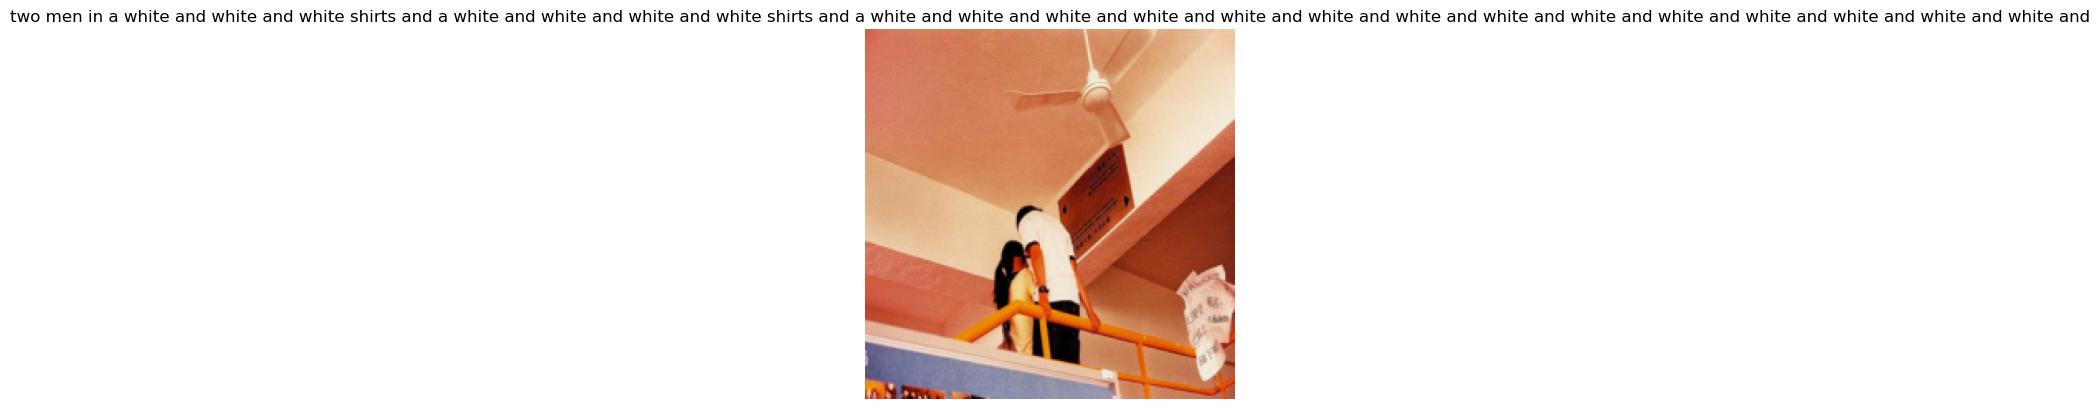

Epoch 14/50 - Train Loss: 3.0958, Val Loss: 3.5261, BLEU: 0.0532, ROUGE-1: 0.2994, ROUGE-2: 0.0952, ROUGE-L: 0.2625, ROUGE-Lsum: 0.2625
Saved checkpoint for epoch 14 at saved_model\LSTM_with_Attention_resnet50_None_epoch_14.pth.gz
Epoch: 15, Batch: 300, Training Loss: 3.06351

Original Caption:  An attractive man and woman in fall coats pose together in the branches of a tree .
Generated Caption: a man in a black jacket and a black hat and a black hat and a woman in a black jacket and a black hat and a black hat and a woman in a black jacket and a black hat and a black dog on the ground <eos>


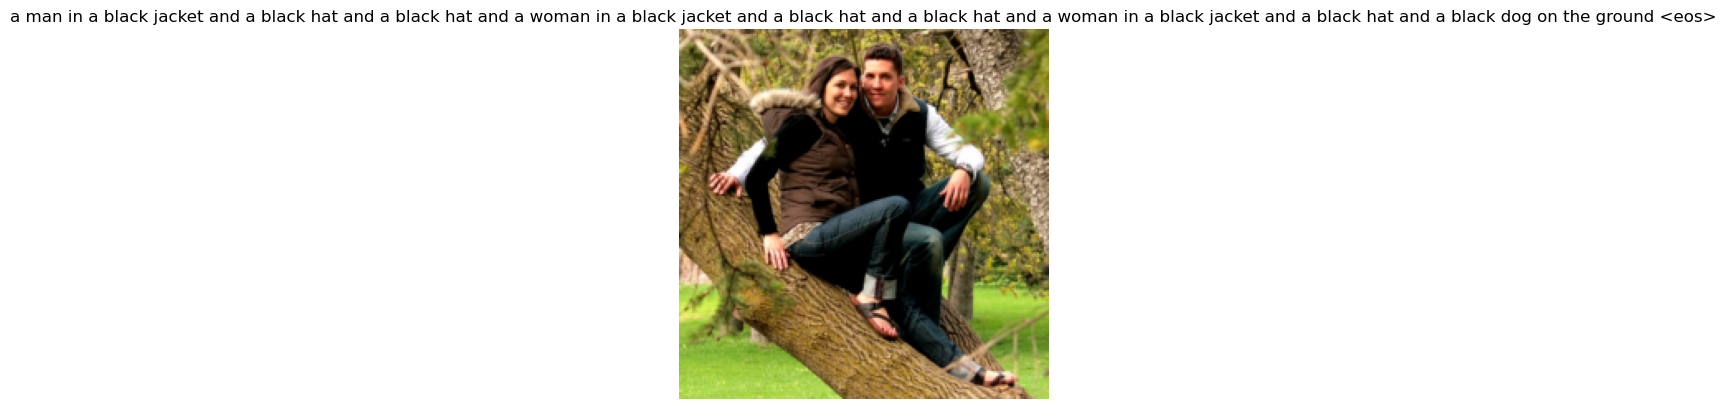

Epoch 15/50 - Train Loss: 3.0471, Val Loss: 3.5280, BLEU: 0.0503, ROUGE-1: 0.2949, ROUGE-2: 0.0919, ROUGE-L: 0.2604, ROUGE-Lsum: 0.2605
Saved checkpoint for epoch 15 at saved_model\LSTM_with_Attention_resnet50_None_epoch_15.pth.gz
Epoch: 16, Batch: 300, Training Loss: 2.89569

Original Caption:  Several people wearing white mask are holding a banner and signs .
Generated Caption: a man in a black shirt is walking down a street with a sign that says <unk> <eos>


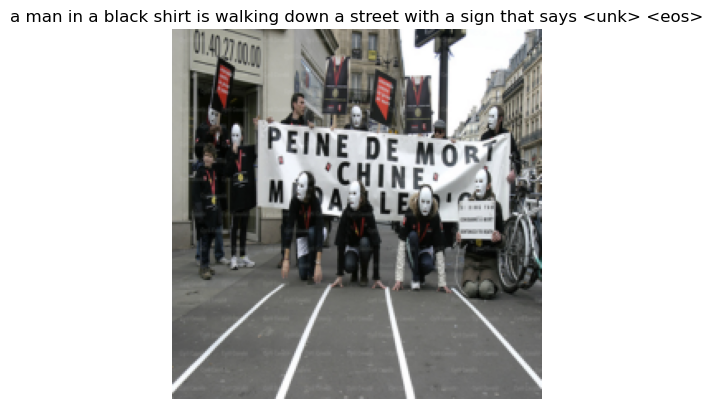

Epoch 16/50 - Train Loss: 3.0013, Val Loss: 3.5297, BLEU: 0.0523, ROUGE-1: 0.2964, ROUGE-2: 0.0935, ROUGE-L: 0.2615, ROUGE-Lsum: 0.2613
Saved checkpoint for epoch 16 at saved_model\LSTM_with_Attention_resnet50_None_epoch_16.pth.gz
Epoch: 17, Batch: 300, Training Loss: 3.09206

Original Caption:  Male teenager wearing red shirt , black and white shorts and white bandanna sitting on black railing .
Generated Caption: a young man in a red shirt and black pants is standing in front of a man in a red shirt <eos>


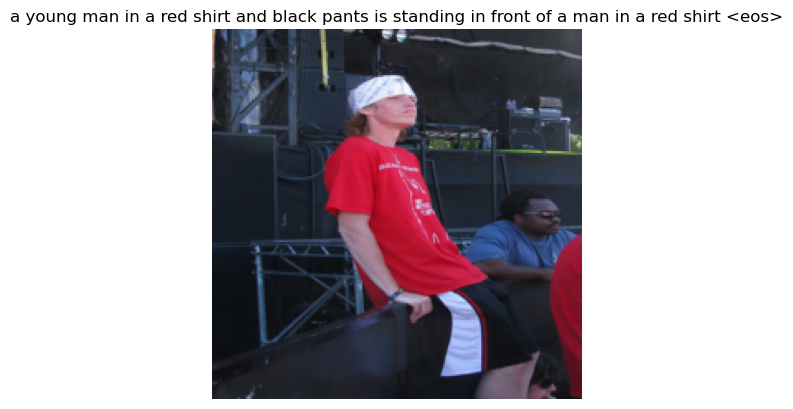

Epoch 17/50 - Train Loss: 2.9568, Val Loss: 3.5320, BLEU: 0.0489, ROUGE-1: 0.2960, ROUGE-2: 0.0917, ROUGE-L: 0.2600, ROUGE-Lsum: 0.2597
Early stopping triggered after epoch 17
Evaluating on the test set...
Test Results - Loss: 3.5953, BLEU: 0.0483, ROUGE-1: 0.2946, ROUGE-2: 0.0906, ROUGE-L: 0.2573, ROUGE-Lsum: 0.2571


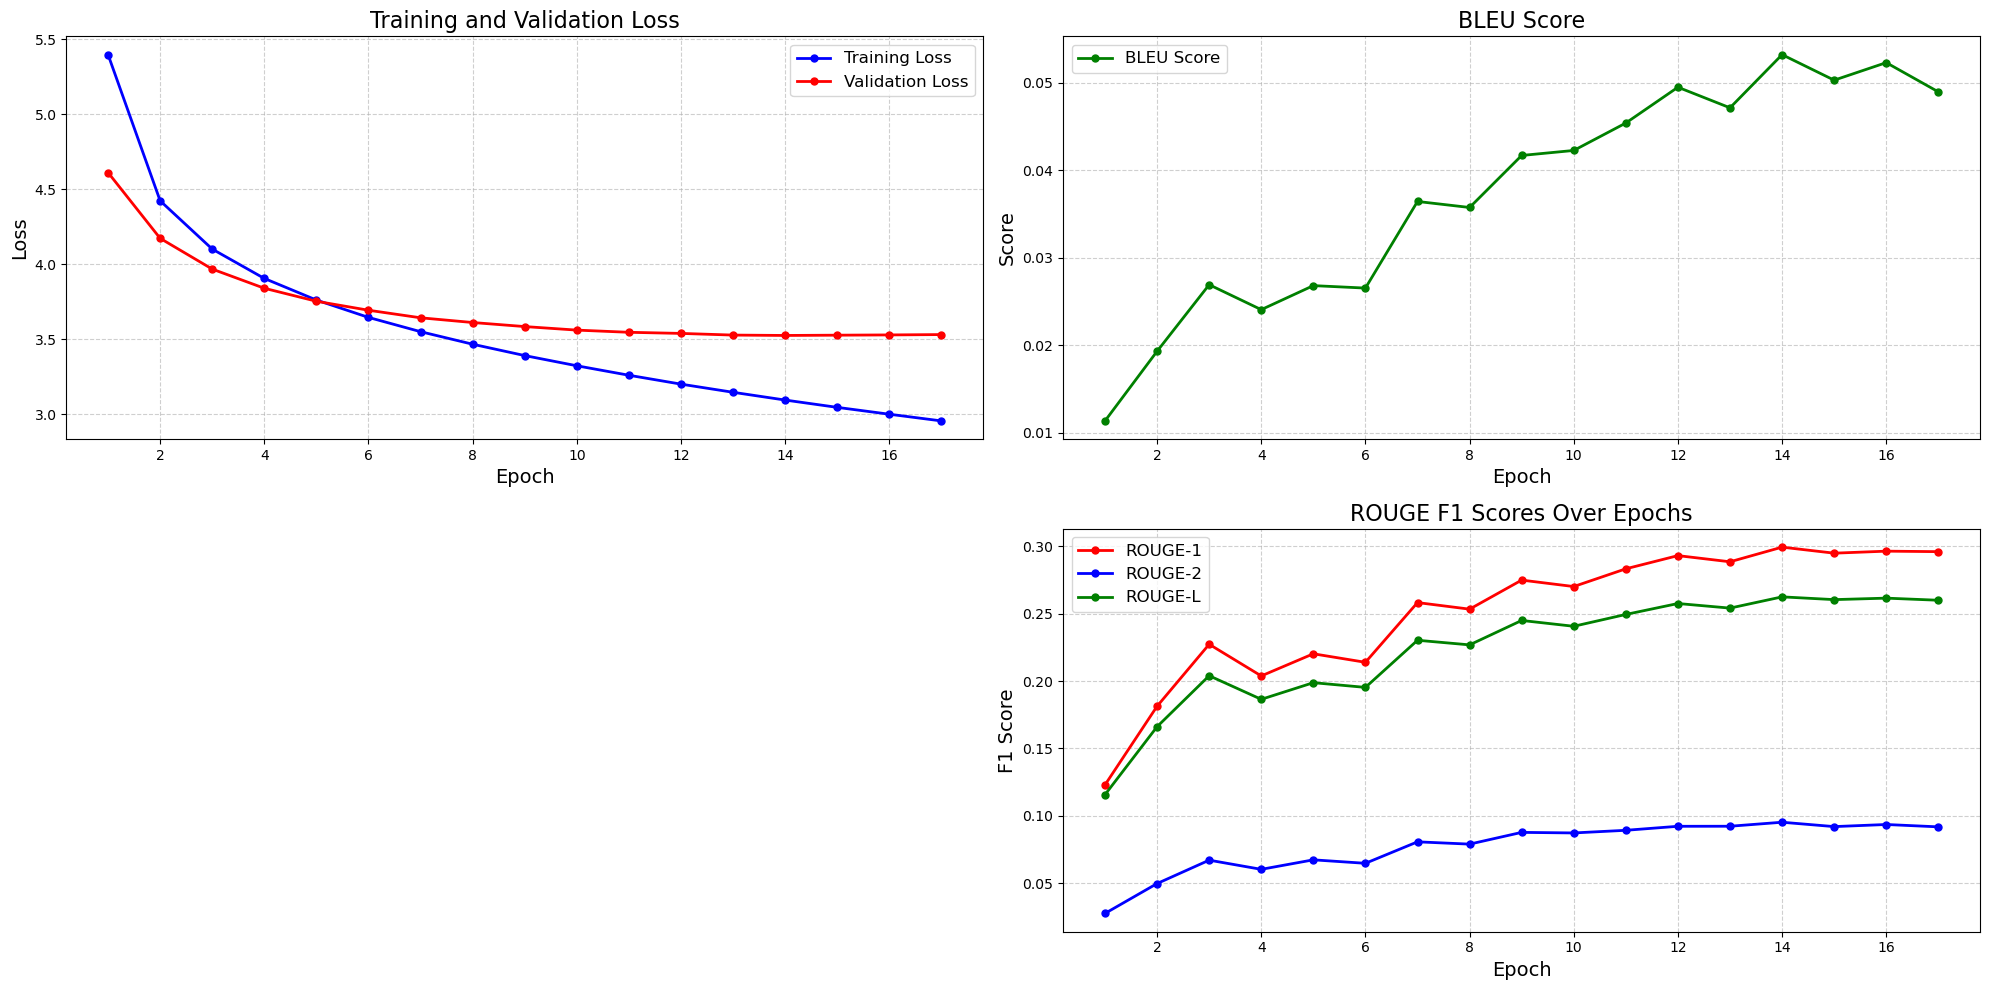

In [19]:
from src.utils import train_model

train_model(
    model=model_Attention,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    vocab=vocab,
    vocab_builder=vocab_builder,
    num_epochs=num_epochs,
    print_every=print_every,
    early_stopping=early_stopping,
    save_dir=save_dir,
    device=device,
    Transform_mean=mean,
    Transform_std=std,
    model_name="LSTM_with_Attention",
    max_sentence_length=max_sentence_length,
    encoder_backbone=backbone,
    transformation_type=transformation
)

## Generating captions from best model - Resnet50

In [1]:
import torch
from pathlib import Path
import os

if Path.cwd().name == 'notebooks':
    os.chdir("..")


from torchvision import transforms
from PIL import Image
from src.utils import load_model, display_image, visualize_attention
from src.models.encoderdecoder import EncoderDecoder
from src.vocab_builder import VocabularyBuilder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

vocab_builder = VocabularyBuilder(min_freq=2, save_path='./saved_model/vocab_full.pth', special_token=True)
vocab = vocab_builder.load_vocab(device)

max_len=50
model_params = {
    "emb_size": 128,
    "vocab_size": len(vocab_builder.vocabulary),
    "attn_size": 64,
    "enc_hidden_size": 2048,
    "dec_hidden_size": 128,
    "drop_prob": 0.2,
    "decoder_type": "lstm",
    "backbone": "resnet50",
    "transformation": None,
    "num_heads": None,
    "num_layers": None,
    "ff_dim": None,
    "max_len": max_len,
    "use_attention": True,
    "device": device,
}

model = EncoderDecoder(**model_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


checkpoint_path = "./saved_model/LSTM_with_Attention_resnet50_None_epoch_8.pth.gz"
model, optimizer, start_epoch = load_model(model, optimizer, checkpoint_path, device=device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def generate_caption_for_image(image_path, visualize_atten=True):
    image = Image.open(image_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        features = model.encoder(transformed_image)
        generated_caption, attention_weights = model.decoder.generate_caption(features=features, vocab=vocab, max_len=max_len)

    caption_text = " ".join(generated_caption)
    print(f"Generated Caption: {caption_text}")

    display_image(transformed_image.squeeze(0).cpu(), caption=caption_text, denormalize=True)

    if attention_weights and visualize_atten:
        visualize_attention(
            image=transformed_image.squeeze(0).cpu(),
            caption=generated_caption,
            attention_weights=attention_weights,
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
            decoder_type='lstm',
            denormalize=True
        )


Loaded model from epoch 8


Processing: img_8914.jpg
Generated Caption: a group of people are sitting on a bench in a wooden floor <eos>


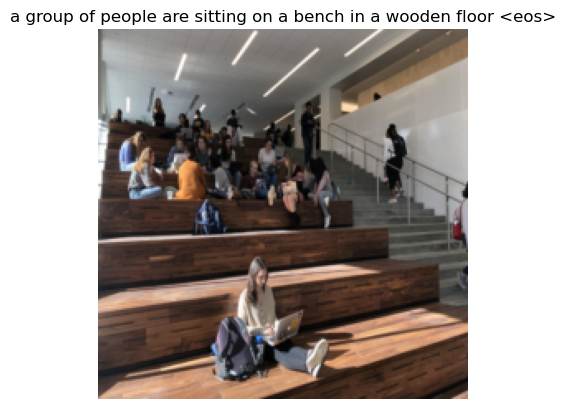

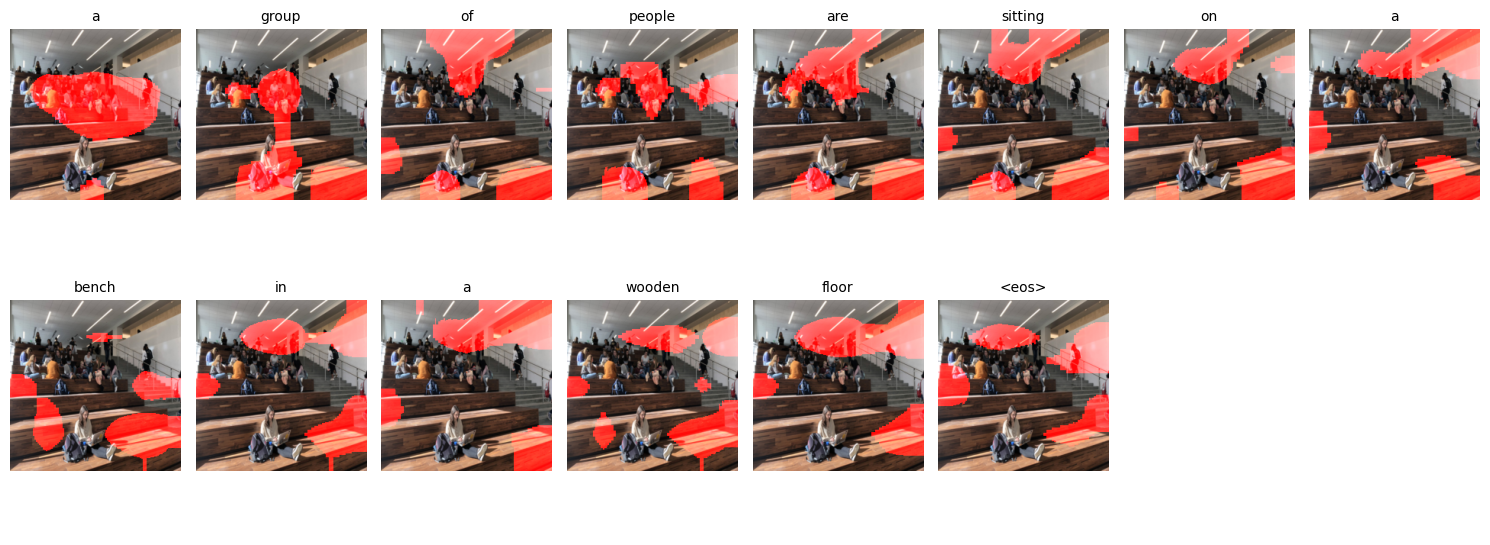

In [3]:
import os

folder_path = "./data/my_test/"

for image_file in os.listdir(folder_path):
    if image_file.endswith(".jpg"): 
        image_path = os.path.join(folder_path, image_file)
        print(f"Processing: {image_file}")
        generate_caption_for_image(image_path, visualize_atten=True)